In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# Progress bar 
from tqdm import tqdm_notebook, tnrange

%matplotlib inline

In [3]:
torch.manual_seed(1)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"device:\n{device}\n")

device = torch.device("cpu")

# LSTM 
Simplest LSTMCell usage example

We try to predict one time-step from a sine wave using a simple LSTM from Pytorch.

torch.Size([200, 1, 1])


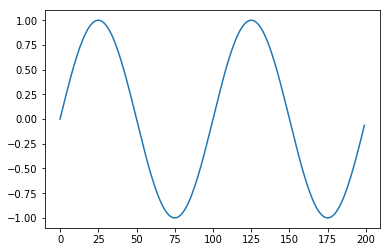

In [6]:
period_samples = 100
periods_count = 2

inputs = torch.tensor([[[math.sin(2 * math.pi * x / float(period_samples))]] for x in
                       range(period_samples * periods_count)])
print(inputs.size())

plt.plot(inputs.squeeze().numpy())
plt.show()

FigureCanvasNbAgg()


CPU times: user 31min 51s, sys: 33 s, total: 32min 24s
Wall time: 2min 17s


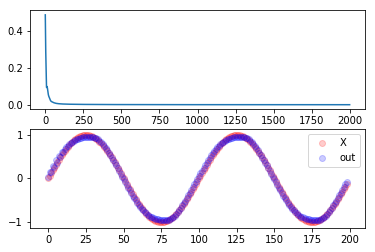

In [8]:
%%time

%matplotlib widget

EPOCHS = 2000
NB_EPOCHS_UPDATE_UI = 25


# LSTM model

model = nn.LSTM(input_size=1, hidden_size=1)
model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

X = inputs[:-1]
X_gpu = X.to(device)

Y = inputs[1:]
Y_gpu = Y.to(device)

h_0 = torch.zeros(1, 1, 1, dtype=torch.float32).to(device)
c_0 = torch.zeros(1, 1, 1, dtype=torch.float32).to(device)

losses = []

def update_plot(fig, ax_loss, ax_fit, losses, X, out_values):
    ax_loss.clear()
    ax_loss.plot(losses)

    ax_fit.clear()
    ax_fit.scatter(range(period_samples * periods_count - 1), X.numpy(), color='red', alpha=0.2, label="X")
    ax_fit.scatter(range(period_samples * periods_count - 1), out_values.numpy(), color='blue', alpha=0.2, label="out")
    ax_fit.legend()

    fig.canvas.draw()


# Progress bar: tnrange, is a wrapper for tqdm_notebook(range(),xxx)
# See https://pypi.org/project/tqdm/#manual
with tnrange(EPOCHS, desc="epoch") as t:
    fig, ax = plt.subplots(2,1)
    ax_loss = ax[0]
    ax_fit = ax[1]

    for epoch in t:
        optimizer.zero_grad()

        # Forward
        out_values, _ = model(X_gpu, (h_0, c_0))

        # Compute the loss, gradients, and update the parameters by calling optimizer.step()
        loss = loss_function(out_values, Y_gpu)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # progress bar
        t.set_postfix(loss=loss.item())

        if epoch % NB_EPOCHS_UPDATE_UI == 0:
            update_plot(fig, ax_loss, ax_fit, losses, X, out_values.cpu().detach())
            
update_plot(fig, ax_loss, ax_fit, losses, X, out_values.cpu().detach())


[0.038821943, 0.13895975, 0.15112405, 0.2808476, 0.25542265, 0.41498837, 0.36400563, 0.5234117, 0.4883204, 0.6033089, 0.6114624, 0.67488456, 0.7086857, 0.74793756, 0.7816056, 0.8119453, 0.83867884, 0.86188805, 0.88171446, 0.8983645, 0.9120964, 0.92320216, 0.93198305, 0.9387245, 0.94367325, 0.9470158, 0.9488572, 0.9491984, 0.9479027, 0.944646, 0.9388455, 0.9295724, 0.91549736, 0.8950044, 0.86671257, 0.83046466, 0.78800434, 0.7419604, 0.69376326, 0.6433579, 0.5905769, 0.535563, 0.4784965, 0.41960385, 0.3591205, 0.2973033, 0.2344094, 0.17071405, 0.10648335, 0.042006392, -0.022452014, -0.08658731, -0.15015009, -0.21281314, -0.27436024, -0.33443302, -0.3928614, -0.44926247, -0.5035013, -0.55521154, -0.6042548, -0.6503382, -0.69330424, -0.7329558, -0.76915896, -0.8018109, -0.83086246, -0.856325, -0.8782765, -0.8968653, -0.91230416, -0.92485917, -0.93482816, -0.94251466, -0.9481988, -0.95210654, -0.95437807, -0.9550309, -0.9539072, -0.9505947, -0.94430554, -0.9337281, -0.91695535, -0.8918141,

FigureCanvasNbAgg()

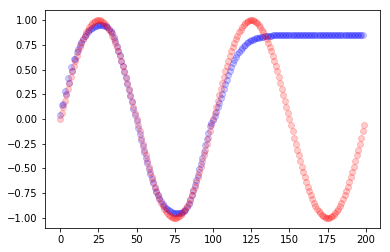

In [9]:
Y_hat = []

# last_prediction = torch.zeros(1, 1, 1, dtype=torch.float32).to(device)
h_0 = torch.zeros(1, 1, 1, dtype=torch.float32).to(device)
c_0 = torch.zeros(1, 1, 1, dtype=torch.float32).to(device)
h_t = h_0
c_t = c_0

out, (h_t, c_t) = model(X_gpu[:-100], (h_t, c_t))
Y_hat += list(out.cpu().data.numpy().flatten())
print(Y_hat)

last_prediction = out[-1].expand(1, -1, -1)

for x in range(100):
    out, (h_t, c_t) = model(last_prediction, (h_t, c_t))
    last_prediction = out
    
    Y_hat.append(out.item())

fig, ax = plt.subplots()
ax.plot(Y_hat, 'bo', alpha=0.2)
ax.plot(inputs.squeeze().numpy(), 'ro', alpha=0.2)
fig.show()

# LSTMCell
Simplest LSTMCell usage example
We try to predict one time-step from a sine wave

torch.Size([200, 1, 1])


FigureCanvasNbAgg()


CPU times: user 31min 13s, sys: 32.4 s, total: 31min 45s
Wall time: 2min 22s


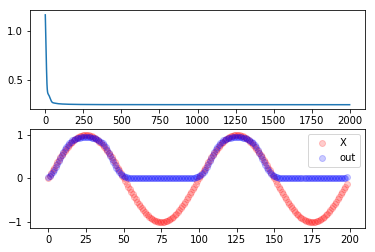

In [10]:
%%time

ax_loss = None
ax_fit = None


EPOCHS = 2000
NB_EPOCHS_UPDATE_UI = 25

period_samples = 100
periods_count = 2
inputs = torch.tensor([[[math.sin(2 * math.pi * x / float(period_samples))]] for x in
                       range(period_samples * periods_count)], dtype=torch.float32)
print(inputs.size())

# LST model
model = nn.LSTMCell(input_size=1, hidden_size=1)
model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

X = inputs[:-1]
X_gpu = X.to(device)

Y = inputs[1:]
Y_gpu = Y.to(device)

losses = []

def update_plot(fig, ax_loss, ax_fit, losses, X, out_values):
    pass
    ax_loss.clear()
    ax_loss.plot(losses)

    ax_fit.clear()
    ax_fit.scatter(range(period_samples * periods_count - 1), X.numpy(), color='red', alpha=0.2, label="X")
    ax_fit.scatter(range(period_samples * periods_count - 1), out_values.numpy(), color='blue', alpha=0.2, label="out")
    ax_fit.legend()

    fig.canvas.draw()

    
# Progress bar: tnrange, is a wrapper for tqdm_notebook(range(),xxx)
# See https://pypi.org/project/tqdm/#manual
with tnrange(EPOCHS, desc="epoch") as progress:
    fig2, ax2 = plt.subplots(2,1)
    ax_loss = ax2[0]
    ax_fit = ax2[1]
    
    for epoch in progress:
        h_0 = torch.zeros(1, 1, dtype=torch.float32).to(device)
        c_0 = torch.zeros(1, 1, dtype=torch.float32).to(device)

        h_1 = h_0
        c_1 = c_0
        
#         out_values = torch.zeros(Y.size()[0], 1, 1, dtype=torch.float32).to(device)
        out_values = []
        
        # Forward
        for i, x in enumerate(X_gpu):
            h_1, c_1 = model(x, (h_1, c_1))
            out_values.append(h_1.clone())

        out_values = torch.stack(out_values, 0)
        
        # Compute the loss, gradients, and update the parameters by calling optimizer.step()
        optimizer.zero_grad()
        loss = loss_function(out_values, Y_gpu)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())           
        progress.set_postfix(loss=loss.item())
        if epoch % NB_EPOCHS_UPDATE_UI == 0:
            update_plot(fig2, ax_loss, ax_fit, losses, X, out_values.cpu().detach())
            
    update_plot(fig2, ax_loss, ax_fit, losses, X, out_values.cpu().detach())

FigureCanvasNbAgg()

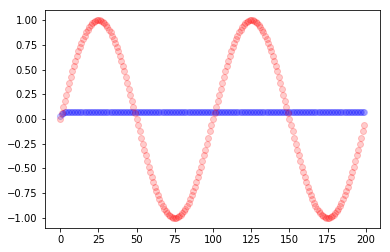

In [8]:
X_range = [i for i in range(200)]
Y_hat = []

last_prediction = torch.zeros(1, 1, dtype=torch.float32).to(device)
h_0 = torch.zeros(1, 1, dtype=torch.float32).to(device)
c_0 = torch.zeros(1, 1, dtype=torch.float32).to(device)

h_1 = h_0
c_1 = c_0

for x in X_range:
    h_1, c_1 = model(last_prediction, (h_1, c_1))
    last_prediction = h_1
    
    Y_hat.append(h_1.item())

fix, ax = plt.subplots()
ax.plot(Y_hat, 'bo', alpha=0.2)
ax.plot(inputs.squeeze().numpy(), 'ro', alpha=0.2)
fig.show()